In [21]:
#Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# Load and inspect the data set
data = pd.read_csv('/content/drive/MyDrive/marketing_campaign.csv', sep='\t')

print("Dataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Shape: (2240, 29)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 1

In [22]:
# Data Preprocessing
# Handle missing values
data['Income'] = data['Income'].fillna(data['Income'].median())

# Create additional features
data['Total_Spending'] = (data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] +
                         data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds'])

data['Total_Children'] = data['Kidhome'] + data['Teenhome']
data['Total_Purchases'] = (data['NumWebPurchases'] + data['NumCatalogPurchases'] +
                          data['NumStorePurchases'] + data['NumDealsPurchases'])

# Convert Dt_Customer to datetime and create customer tenure
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')
data['Customer_Tenure'] = (data['Dt_Customer'].max() - data['Dt_Customer']).dt.days

print("Data preprocessing completed!")
print(f"Dataset shape after preprocessing: {data.shape}")

Data preprocessing completed!
Dataset shape after preprocessing: (2240, 33)


In [23]:
# ==========================
# 1. pie chart: Avg Spending by catogory
# ==========================
def plot_spending_distribution(data):
    import matplotlib.pyplot as plt

    categories = ['MntWines', 'MntFruits', 'MntMeatProducts',
                  'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
    avg_spending = data[categories].mean()

    plt.figure(figsize=(6,6))
    plt.pie(avg_spending, labels=[c.replace('Mnt','') for c in categories],
            autopct='%1.1f%%', startangle=120, colors=plt.cm.Set3.colors)
    plt.title('Average Customer Spending Breakdown by Category', fontsize=14)
    plt.tight_layout()
    plt.show()

    print("💡 Insight: The pie chart reveals which product categories dominate customer purchases — often, wine and meat products take the largest share.")


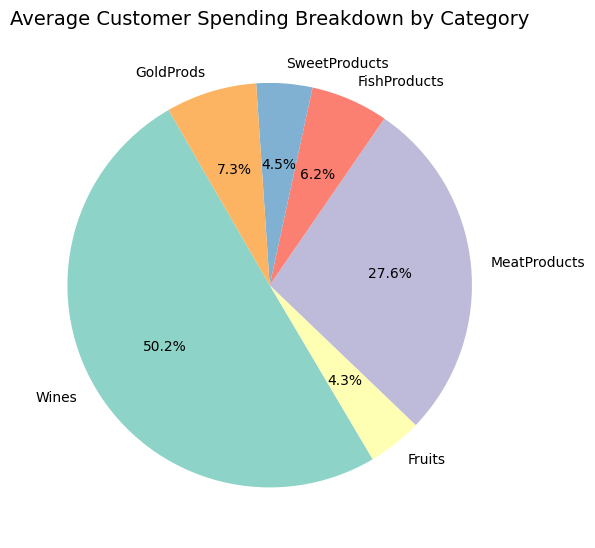

💡 Insight: The pie chart reveals which product categories dominate customer purchases — often, wine and meat products take the largest share.


In [24]:
plot_spending_distribution(data)

In [25]:
# ==========================
# 2. line Plot: Average Spending by Number of Total Purchases
# ==========================
def plot_purchases_vs_spending(data):
    import matplotlib.pyplot as plt
    import seaborn as sns

    grouped = data.groupby('Total_Purchases')['Total_Spending'].mean().reset_index()

    plt.figure(figsize=(8,5))
    sns.lineplot(x='Total_Purchases', y='Total_Spending', data=grouped, marker='o', color='teal', linestyle='--')
    plt.title('Average Spending by Number of Total Purchases', fontsize=14)
    plt.xlabel('Total Purchases')
    plt.ylabel('Average Spending ($)')

    # Annotation
    max_point = grouped.loc[grouped['Total_Spending'].idxmax()]
    plt.text(max_point['Total_Purchases'], max_point['Total_Spending']*0.95,
             f"Peak Avg Spend = {max_point['Total_Spending']:.0f}", color='red')

    plt.tight_layout()
    plt.show()

    print("💡 Insight: The line chart shows a strong increasing trend — as total purchases increase, spending also rises significantly.")


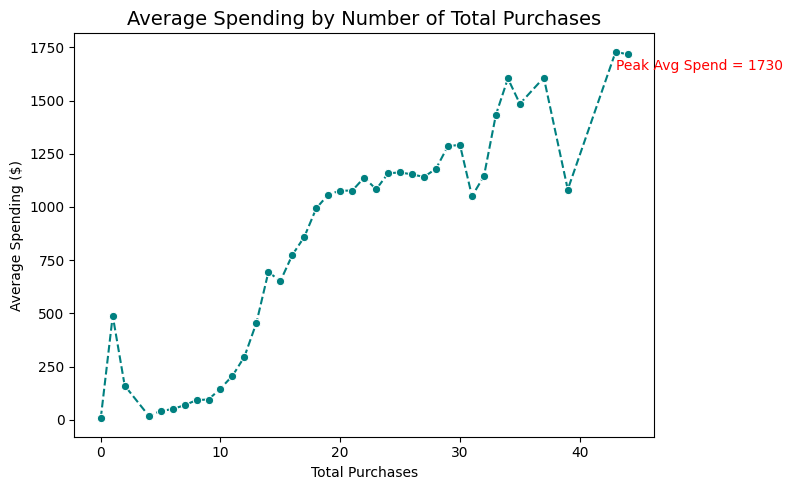

💡 Insight: The line chart shows a strong increasing trend — as total purchases increase, spending also rises significantly.


In [26]:
plot_purchases_vs_spending(data)

In [27]:
# ===========================================
#3.Box plot: Income Distribution by Number of Children
# ===========================================
def plot_income_vs_children(data):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8,5))
    sns.boxplot(x='Total_Children', y='Income', data=data, palette='pastel')
    plt.title('Income Distribution by Number of Children', fontsize=14)
    plt.xlabel('Total Children')
    plt.ylabel('Income ($)')

    # Text Annotation
    plt.text(0.5, data['Income'].max()*0.9, 'Observation: Families with fewer children tend to have higher income.',
             color='black', fontsize=10)
    plt.tight_layout()
    plt.show()

    print("💡 Insight: The box plot suggests that customers with more children generally have slightly lower median incomes, likely due to higher household expenses.")



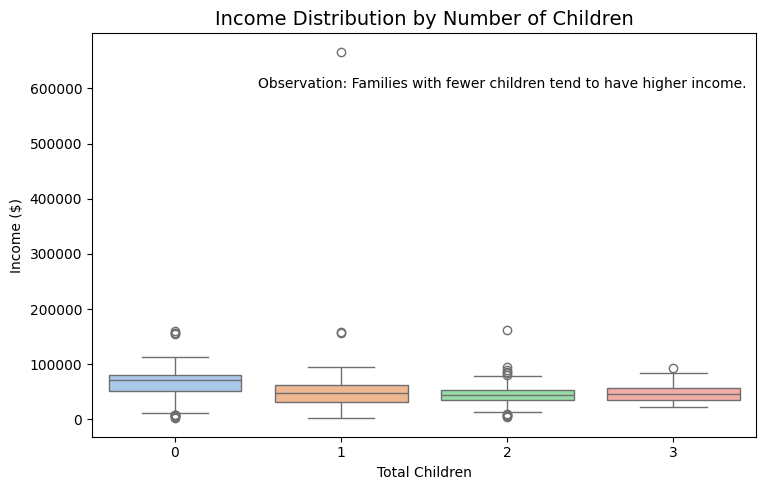

💡 Insight: The box plot suggests that customers with more children generally have slightly lower median incomes, likely due to higher household expenses.


In [28]:
plot_income_vs_children(data)

In [29]:
# ===========================================
#4.Elbow Plot Function: Determine Optimal k
# ===========================================
def plot_iv_elbow_plot(df_scaled):
    """
    Generates an Elbow Plot to justify the choice of K clusters.
    """
    inertia = []
    # Test K from 1 to 10
    max_k = 10
    for i in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(df_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), inertia, marker='o', linestyle='--', color='#e74c3c')
    plt.title('iv. Elbow Method for Optimal K', fontsize=16)
    plt.xlabel('Number of Clusters (K)', fontsize=14)
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=14)

    # Annotation for the chosen K (K=3 or K=4 are often seen as the "elbow" here)
    elbow_k = K_CLUSTERS
    plt.axvline(elbow_k, color='green', linestyle='-', linewidth=2, label=f'Chosen K = {elbow_k}')
    plt.scatter(elbow_k, inertia[elbow_k-1], color='green', s=200, label=f'Elbow at K={elbow_k}')

    # In-graph Annotation and Insight
    plt.text(0.95, 0.95,
             f"Insight:\nThe elbow at K={elbow_k} indicates diminishing returns in\nreducing inertia, suggesting {elbow_k} clusters is a suitable balance.",
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7))

    plt.legend()
    plt.tight_layout()
    plt.savefig('plot_iv_elbow_plot.png')
    plt.show()

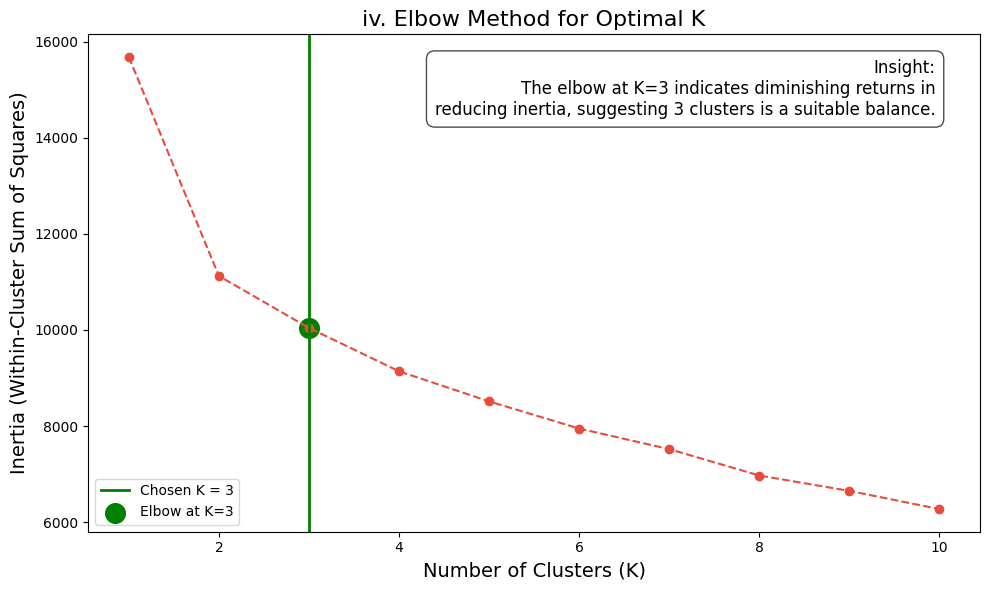

In [30]:
# Feature Engineering for Clustering
data['Age'] = 2024 - data['Year_Birth'] # Assuming current year is 2024

# Select features for clustering
features_for_clustering = [
    'Income',
    'Recency',
    'Total_Spending',
    'Total_Purchases',
    'Customer_Tenure',
    'Total_Children',
    'Age'
]

df_clustering = data[features_for_clustering]

# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Define K_CLUSTERS for the elbow plot annotation
K_CLUSTERS = 3 # This can be adjusted based on the elbow plot visual

# Now, call the elbow plot function
plot_iv_elbow_plot(df_scaled)

In [31]:
# ===========================================
# 5. Perform K-Means Clustering and Visualization
# ===========================================
def perform_kmeans_clustering(data, n_clusters=3):
    """
    Perform K-Means clustering on key features and visualize the clusters.
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans

    # Select important features
    features = data[['Income','Total_Spending','Total_Purchases','Customer_Tenure']]

    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(scaled_features)

    # Cluster centers (scaled → back to readable scale)
    centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                           columns=features.columns)
    centers['Cluster'] = range(n_clusters)

    # ==========================
    # Scatter Plot of Clusters
    # ==========================
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='Income', y='Total_Spending', hue='Cluster',
                    data=data, palette='Set1', alpha=0.7)
    plt.title('Customer Segments based on Income and Spending')
    plt.xlabel('Income')
    plt.ylabel('Total Spending')

    # Annotate cluster centers
    for i, row in centers.iterrows():
        plt.text(row['Income'], row['Total_Spending']+200,
                 f"Cluster {int(row['Cluster'])}", color='black', weight='bold')

    plt.legend(title='Cluster')
    plt.show()

    # ==========================
    # Display Cluster Insights
    # ==========================
    cluster_summary = data.groupby('Cluster')[['Income','Total_Spending','Total_Purchases','Customer_Tenure']].mean().round(2)
    print("🧭 Cluster Summary (Average Values):\n")
    print(cluster_summary)
    print("\n🎯 Insights:")
    for cluster in cluster_summary.index:
        income = cluster_summary.loc[cluster, 'Income']
        spend = cluster_summary.loc[cluster, 'Total_Spending']
        purchases = cluster_summary.loc[cluster, 'Total_Purchases']

        if income > cluster_summary['Income'].mean():
            income_level = "High Income"
        else:
            income_level = "Low to Mid Income"

        if spend > cluster_summary['Total_Spending'].mean():
            spend_level = "High Spending"
        else:
            spend_level = "Low to Moderate Spending"

        print(f" - Cluster {cluster}: {income_level}, {spend_level}, Avg Purchases: {purchases}")

    print("\n✅ K-Means clustering and visualization completed!\n")


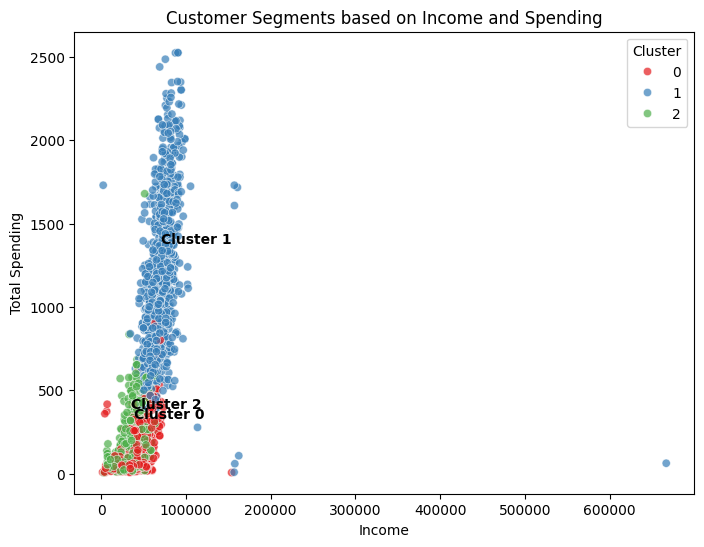

🧭 Cluster Summary (Average Values):

           Income  Total_Spending  Total_Purchases  Customer_Tenure
Cluster                                                            
0        39208.37          130.87             8.68           174.56
1        71235.67         1183.64            21.79           379.88
2        35320.67          187.62            10.44           527.55

🎯 Insights:
 - Cluster 0: Low to Mid Income, Low to Moderate Spending, Avg Purchases: 8.68
 - Cluster 1: High Income, High Spending, Avg Purchases: 21.79
 - Cluster 2: Low to Mid Income, Low to Moderate Spending, Avg Purchases: 10.44

✅ K-Means clustering and visualization completed!



In [32]:
perform_kmeans_clustering(data, n_clusters=3)

In [33]:
# ===========================================
# 6. line fitting
# ===========================================

def plot_v_line_fit(df, regressor, r2):
    """
    Generates a Scatter Plot with the fitted line for Linear Regression.
    Relationship: Total Spending -> Num Catalog Purchases
    """
    X = df[['Total_Spending']].values
    y = df['NumCatalogPurchases'].values
    y_pred = regressor.predict(X)

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='#9b59b6', s=50, alpha=0.6)
    plt.plot(X, y_pred, color='red', linewidth=3, label=f'Linear Fit: $Y = {regressor.coef_[0]:.3f}X + {regressor.intercept_:.3f}$')
    plt.title('v. Linear Fitting: Total Spending vs. Catalog Purchases', fontsize=16)
    plt.xlabel('Total Spending ($)', fontsize=14)
    plt.ylabel('Number of Catalog Purchases', fontsize=14)

    # In-graph Annotation and Insight
    plt.text(0.95, 0.95,
             f"Result:\nR-squared = {r2:.3f}\n\nInsight:\nA strong positive linear relationship exists. For every $1 spent\n(Total Spending), Catalog Purchases increase by {regressor.coef_[0]:.3f}.\nThis confirms catalogs are a key driver for high-value customers.",
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

    plt.legend()
    plt.tight_layout()
    plt.savefig('plot_v_line_fit.png')
    plt.show()

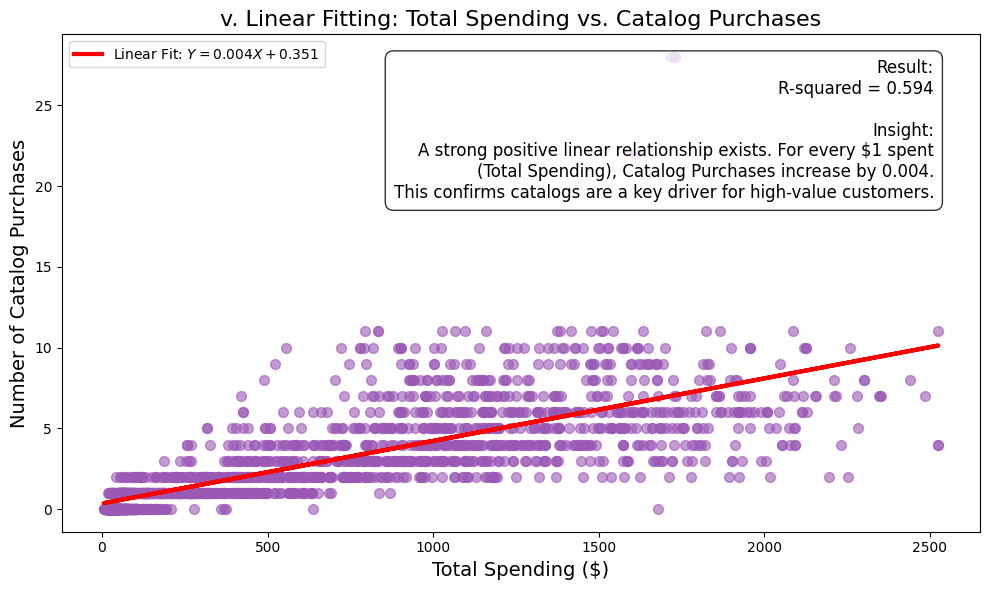

In [34]:
# Prepare data for linear regression
df = data.copy()
X = df[['Total_Spending']]
y = df['NumCatalogPurchases']

# Split data (optional, but good practice for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions on the test set and calculate R-squared
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Call the plotting function
plot_v_line_fit(df, regressor, r2)